### Implemented Filters Work on Static Images Demonstration

In [27]:
import torch
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import enhancer_block

In [40]:
plt.style.use('ggplot')

In [2]:
image_path = './data/lego-up-5/test_400/0011.png'
image = Image.open(image_path)
image = np.array(image)

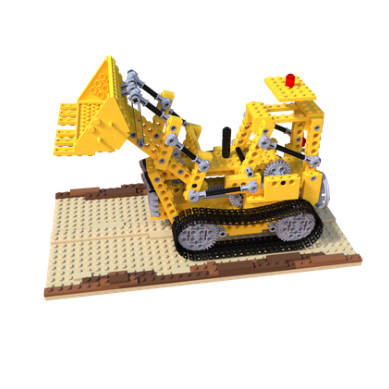

In [3]:
plt.imshow(image)
plt.axis('off')
plt.show()

#### Introduce Salt-and-Pepper Noise

In [4]:
noisy_image = image.copy()
num_salt = int(0.01 * image.size)
salt_coords = [np.random.randint(0, i-1, num_salt) for i in image.shape]
noisy_image[salt_coords[0], salt_coords[1], :] = 255


num_pepper = int(0.01 * image.size)
pepper_coords = [np.random.randint(0, i-1, num_pepper) for i in image.shape]
noisy_image[pepper_coords[0], pepper_coords[1], :] = 0 

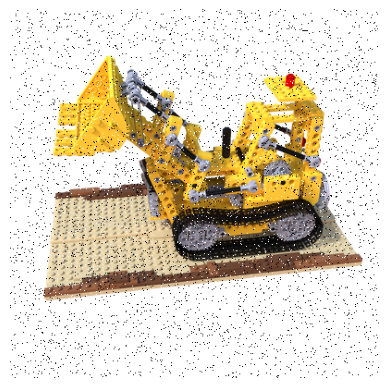

In [5]:
plt.imshow(noisy_image)
plt.axis('off')
plt.show()

#### Introduce Gaussian Noise

In [6]:
mean = 0
sigma = 30 

gaussian_noise = np.random.normal(mean, sigma, image.shape)
g_noisy_image = image + gaussian_noise
g_noisy_image = np.clip(g_noisy_image, 0, 255).astype(np.uint8)

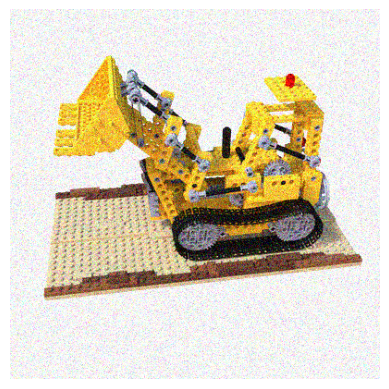

In [7]:
plt.imshow(g_noisy_image)
plt.axis('off')
plt.show()

#### Gaussian Filtering

In [8]:
gaussian_filtered_tensor = enhancer_block.gaussian_filtering(g_noisy_image)
g_image = gaussian_filtered_tensor.numpy().astype(np.uint8)

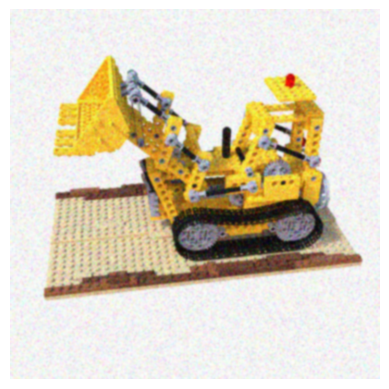

In [9]:
plt.imshow(g_image)
plt.axis('off')
plt.show()

#### Bilateral Filtering

In [10]:
bilateral_filtered_tensor = enhancer_block.bilateral_filtering(g_noisy_image)
bilateral_image = bilateral_filtered_tensor.numpy().astype(np.uint8)

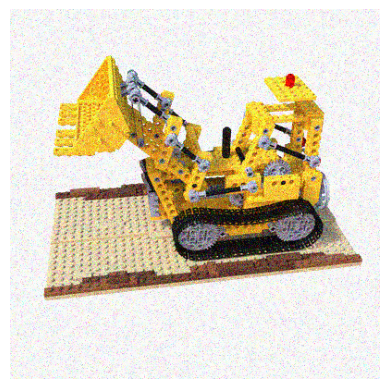

In [11]:
plt.imshow(bilateral_image)
plt.axis('off')
plt.show()

#### Guided Filtering

In [12]:
guided_tensor = enhancer_block.guided_filtering(torch.tensor(g_noisy_image, dtype=torch.float32) / 255.0)
guided_image = (guided_tensor.cpu().numpy() * 255).astype(np.uint8)

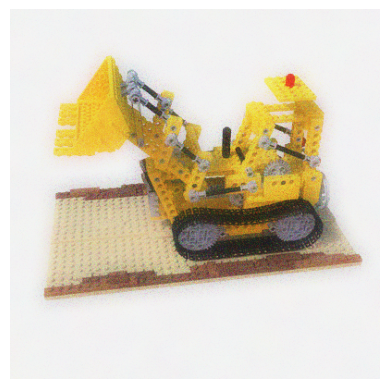

In [13]:
plt.imshow(guided_image)
plt.axis('off')
plt.show()

#### Median Filtering

In [14]:
median_filtered_image_tensor = enhancer_block.median_filtering(noisy_image)
median_filtered_image = median_filtered_image_tensor.numpy().astype(np.uint8)

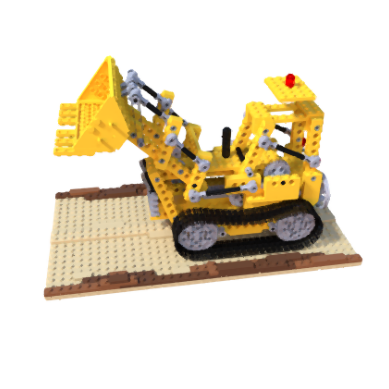

In [15]:
plt.imshow(median_filtered_image)
plt.axis('off')
plt.show()

### Projection Module Trained for 30k Iterations – Loss and PSNR plots

Loading the metrics data

In [46]:
losses_10k = np.load('30k_iterations_metrics/losses_10k.npy')
psnrs_10k = np.load('30k_iterations_metrics/psnrs_10k.npy')

losses_20k = np.load('30k_iterations_metrics/losses_20k.npy')
psnrs_20k = np.load('30k_iterations_metrics/psnrs_20k.npy')

losses_30k = np.load('30k_iterations_metrics/losses30k.npy')
psnrs_30k = np.load('30k_iterations_metrics/psnrs30k.npy')

In [70]:
print(losses_10k.mean())
print(psnrs_10k.mean())

print(losses_20k.mean())
print(psnrs_20k.mean())

print(losses_30k.mean())
print(psnrs_30k.mean())

0.0004349206174414543
33.79194051725199
0.002168486011930437
27.22989168520892
0.0006088823099406247
32.47509693801433


Definition of the exponential moving average smoothing method to de-noise the data before plotting

In [47]:
def exponential_moving_average(seq, alpha=0.1):
    """
    Compute the exponential moving average (EMA) of a speficified sequence.

    Args:
        seq (list or np.ndarray): sequence of numeric values 
        alpha (float): smoothing factor; smaller = smoother (default: 0.1)

    Returns:
        np.ndarray: smoothed values
    """
    ema = []
    current_ema = seq[0]
    for i in seq:
        current_ema = alpha * i + (1 - alpha) * current_ema
        ema.append(current_ema)
    return np.array(ema)

In [62]:
loss_10k_smooth = exponential_moving_average(losses_10k)
psnr_10k_smooth = exponential_moving_average(psnrs_10k)

loss_20k_smooth = exponential_moving_average(losses_20k)
psnr_20k_smooth = exponential_moving_average(psnrs_20k)

loss_30k_smooth = exponential_moving_average(losses_30k)
psnr_30k_smooth = exponential_moving_average(psnrs_30k)

#### Create common plots for loss and PSNR for each training step 

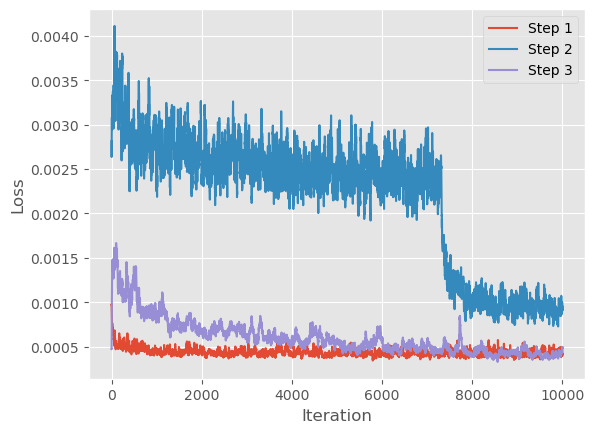

In [60]:
plt.plot(loss_10k_smooth, label='Step 1')
plt.plot(loss_20k_smooth, label='Step 2')
plt.plot(loss_30k_smooth, label='Step 3')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.savefig('smoothed_psnr_loss.png')

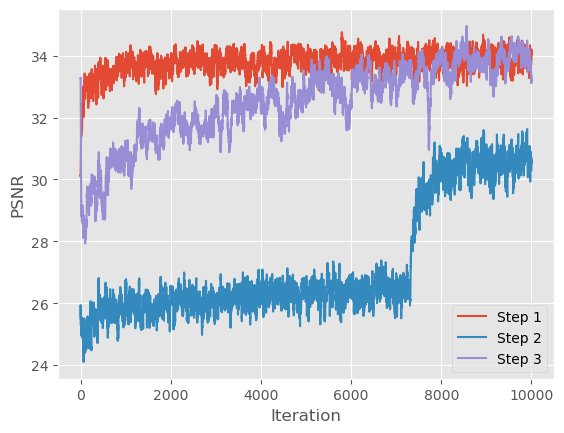

In [61]:
plt.plot(psnr_10k_smooth, label='Step 1')
plt.plot(psnr_20k_smooth, label='Step 2')
plt.plot(psnr_30k_smooth, label='Step 3')
plt.xlabel('Iteration')
plt.ylabel('PSNR')
plt.grid(True)
plt.legend()
plt.savefig('smoothed_psnr.png')

### Plots creation for each step metrics with raw and smoothed curves 

In [83]:
def plot_psnr_and_loss(loss_raw, loss_smoothed,pnsr_raw, psnr_smoothed, iteration):
    """
    Plot the PSNR and loss values.

    Args:
        loss_raw (list): raw loss values
        loss_smoothed (list): smoothed loss values
        pnsr_raw (list): raw PSNR values
        psnr_smoothed (list): smoothed PSNR values
        iteration (int): number of iterations
    """
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(loss_raw, label='Raw Loss', alpha=0.5, color='royalblue')
    plt.plot(loss_smoothed, label='Smoothed Loss', color='navy')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(pnsr_raw, label='Raw PSNR', alpha=0.5, color='orange')
    plt.plot(psnr_smoothed, label='Smoothed PSNR', color='darkorange')
    plt.xlabel('Iteration')
    plt.ylabel('PSNR')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'psnr_loss_plot_{iteration}k.png')
    plt.show()

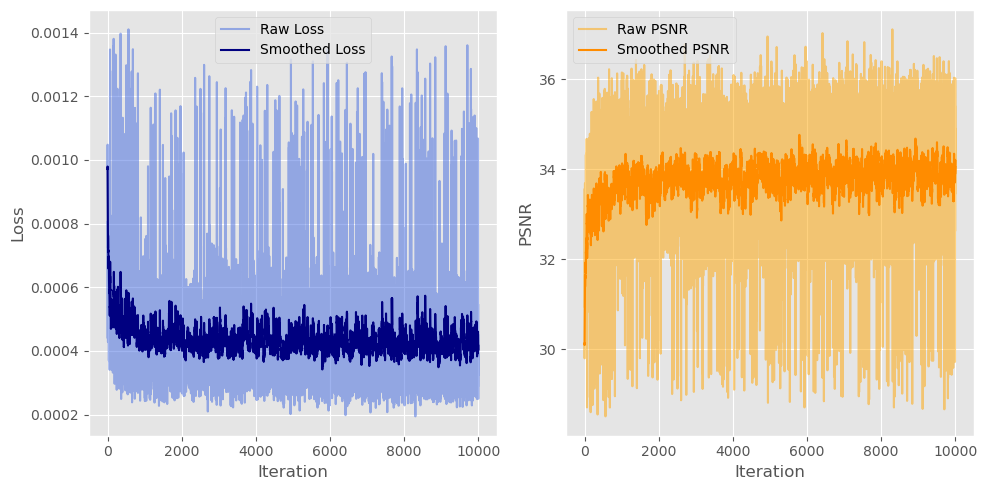

In [84]:
plot_psnr_and_loss(losses_10k, loss_10k_smooth, psnrs_10k, psnr_10k_smooth, 10)

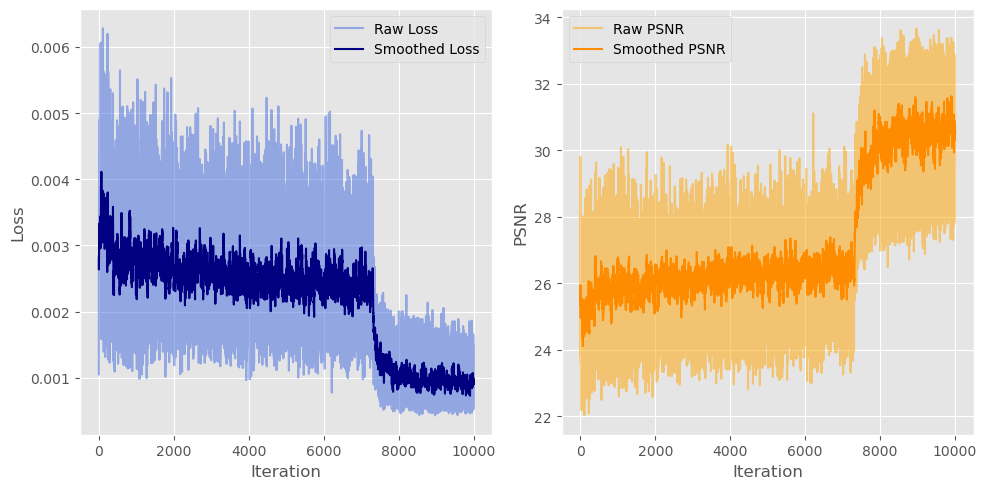

In [85]:
plot_psnr_and_loss(losses_20k, loss_20k_smooth, psnrs_20k, psnr_20k_smooth, 20)

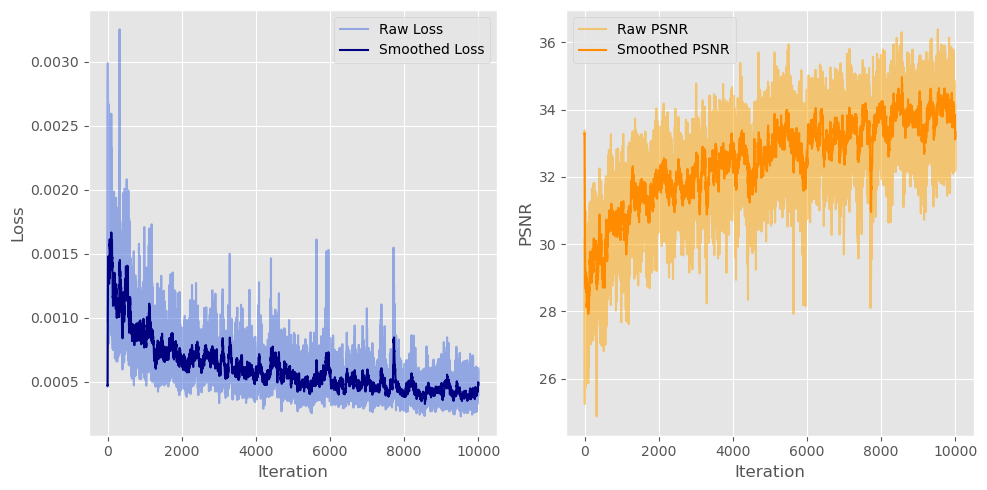

In [86]:
plot_psnr_and_loss(losses_30k, loss_30k_smooth, psnrs_30k, psnr_30k_smooth, 30)

#### Create an aggregated table of the results

In [31]:
def read_and_summarise(df_file_path):
     """
     Reads a CSV file and summarises the data by calculating the mean and standard deviation.
     Args:
          df_file_path (str): path to the csv file
     Returns:
          pd.DataFrame: DataFrame containing the mean and standard deviation for each column
     Raises:
          FileNotFoundError: if the specified file does not exist
     """
     if not os.path.exists(df_file_path):
          raise FileNotFoundError(f"File {df_file_path} does not exist.")
     df = pd.read_csv(df_file_path)
     df_summary = pd.DataFrame({
          'Metric': df.columns,
          'Mean': df.mean().values,
          'Std': df.std(ddof=0).values
     })

     return df_summary